In [26]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(tidymodels)



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ scales::discard()    masks purrr::discard()
✖ dplyr::filter()      masks stats::filter()
✖ recipes::fixed()     masks stringr::fixed()
✖ dplyr::lag()         masks stats::lag()
✖ yardstick::spec()    masks readr::spec()
✖ recipes::step()      masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



Since our prompt only used the player’s age, experience, gender, and subscription to a game-related newsletter as the predictors, The dataset used in this study is players.csv, which contains player characteristics and game-related behaviors. The predictor variables are the players’ age, experience, gender, and subscription to a game-related newsletter, and the predicted response variable is the total playtime. 

In [19]:
players <- read_csv('https://raw.githubusercontent.com/rjmc2006/DSCI-100_group_project/refs/heads/main/players.csv')
sessions <- read_csv('https://raw.githubusercontent.com/rjmc2006/DSCI-100_group_project/refs/heads/main/sessions.csv')
head(players)
head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.72e+12,1.72e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.72e+12,1.72e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72e+12,1.72e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72e+12,1.72e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.72e+12,1.72e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.72e+12,1.72e+12


To obtain a cleaner dataset, we utilize the select function to rid the dataset of unnecessary variables, including name and hashedEmail. 

In [35]:
players_use <- players |>
    select(-name,-hashedEmail)


head(players_use)

experience,subscribe,played_hours,gender,Age
<chr>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


With a cleaner dataset, we need to first wrangle the data so that it is usable as predictors in our model. Regardless of what model we used, the predictors can only be numerical variables. Thus, we need to change the categorical variables, including experience and gender, and the logical variable, which is subscribe, to double variables. In order to achieve this, we used the mutate function to assign each category of the variable a number. For experience, we assigned "Beginner" to 1, "Amateur" to 2, "Regular" to 3, "Veteran" to 4, and "Pro" to 5. For subscribe, 1 correspond to TRUE and 0 correspond to FALSE. For gender, we assigned "Male" to 1, "Female" to 2, "Non-binary" to 3, "Transgender" to 4, "Agender" to 5, "Two-Spirited" to 6, "Prefer not to say" to 7, and "Other" to 8. 

In [21]:
players_numeric <- players_use |>
    mutate(
    experience = case_when(
      experience == "Beginner" ~ 1,
      experience == "Amateur" ~ 2,
      experience == "Regular" ~ 3,
      experience == "Veteran" ~ 4,
      experience == "Pro" ~ 5),
    subscribe = as.numeric(subscribe),  # 1 = TRUE, 0 = FALSE
    gender = case_when(
      gender == "Male" ~ 1,
      gender == "Female" ~ 2,
      gender == "Non-binary" ~ 3,
      gender == "Transgender" ~ 4,
      gender == "Agender" ~ 5,
      gender == "Two-Spirited" ~ 6,
      gender == "Prefer not to say" ~ 7,
      gender == "Other" ~ 8))
head(players_numeric)

experience,subscribe,played_hours,gender,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,1,30.3,1,9
4,1,3.8,1,17
4,0,0.0,1,17
2,1,0.7,2,21
3,1,0.1,1,21
2,1,0.0,2,17


In [22]:
str(players_numeric)

tibble [196 × 5] (S3: tbl_df/tbl/data.frame)
 $ experience  : num [1:196] 5 4 4 2 3 2 3 2 2 4 ...
 $ subscribe   : num [1:196] 1 1 0 1 1 1 1 0 1 1 ...
 $ played_hours: num [1:196] 30.3 3.8 0 0.7 0.1 0 0 0 0.1 0 ...
 $ gender      : num [1:196] 1 1 1 2 1 2 2 1 1 2 ...
 $ Age         : num [1:196] 9 17 17 21 21 17 19 21 17 22 ...


In [23]:
write.csv(players_numeric, "players_numeric_cleaned.csv", row.names = FALSE)

With a workable dataset, we need to determine a suitable model that will yield the greatest accuracy. Our response variable is the numerical variable played_hours, so our model must be a regression model. In order to decide between linear regression model and k-nn regression model, we can check the correlation between the variables.

In [24]:
cor_chart<-cor(players_numeric, use="complete.obs")
cor_chart[3, ]

experience    subscribe played_hours       gender          Age 
-0.002188147  0.115021354  1.000000000 -0.007135580 -0.055094146

As shown above, the correlation between the variables are relatively weak. Thus, a k-nn regression is better in our case.

Rows: 196 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): experience, subscribe, played_hours, gender, Age

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 30 rows.
               ✖ Assigned data has 31 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 31 to size 30.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 28 rows.
               ✖ Assigned data has 29 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rh

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,18.80356,3,7.306771,Preprocessor1_Model02


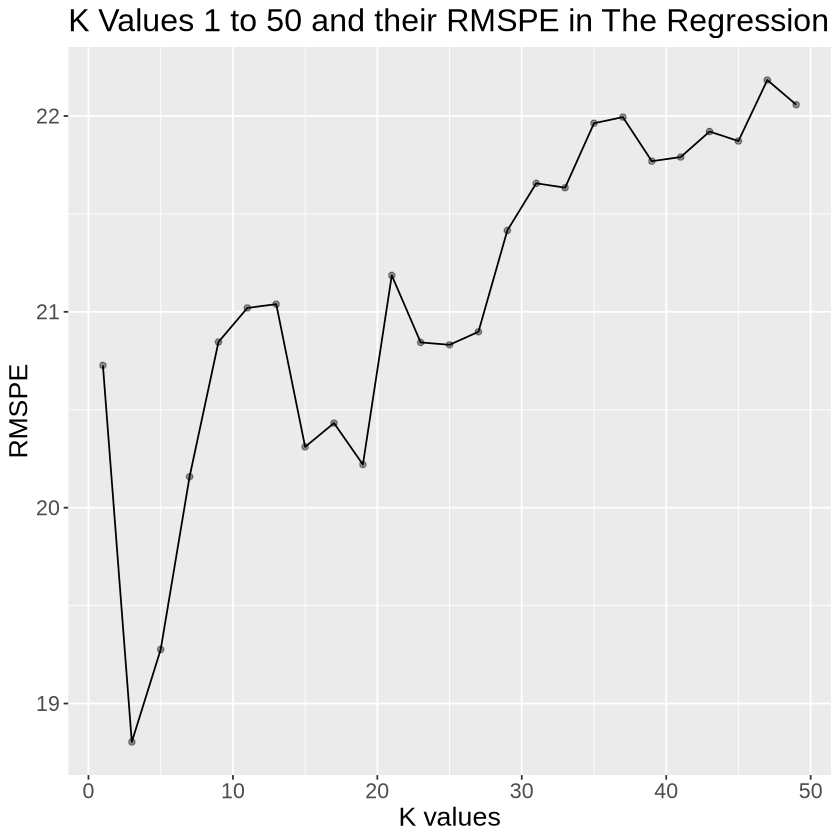

In [28]:
set.seed(2025)
 
numeric_cleaned_players<- read_csv("players_numeric_cleaned.csv")
# head(numeric_cleaned_players)
 
#split of data set for testing and training
players_split <- initial_split(numeric_cleaned_players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)
 
 
#model spec
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
   set_engine("kknn") |>
   set_mode("regression")
 
#model recipe
players_recipe <- recipe(played_hours ~ ., data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())
 
#preping for cross-validation
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)
 
#model workflow
players_fit <- workflow() |>
   add_recipe(players_recipe) |>
   add_model(players_spec)
 
 
#creating K values for tune testing in our workflow
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))
 
player_tuning_results <- players_fit |>
   tune_grid(resamples = players_vfold, grid = gridvals) |>
   collect_metrics() |>
   filter(.metric == "rmse")
# player_tuning_results
 
#add options graph size editor here
rmse_best_k_plot <- player_tuning_results |>
   ggplot(aes(x= neighbors, y=mean)) +
   geom_line()+

   geom_point(alpha = 0.4) +
   # geom_line() +
   labs(x='K values', y='RMSPE', title='K Values 1 to 50 and their RMSPE in The Regression Model') +
   theme(text = element_text(size = 16))
rmse_best_k_plot

 
#finding the best k value which ends up being k = 3
players_best_k <- player_tuning_results |>
   filter(mean == min(mean))
players_best_k
 
#building of proper model with k = 3. This was determined above through cross-validation.

In [36]:
set.seed(2024)
 
mim_k <- players_best_k |> pull(neighbors)
 
#model spec
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = mim_k) |>
   set_engine("kknn") |>
   set_mode("regression")
 
#No need for a new recipe old one will work fine for the final regression model
 
#model workflow
players_best_fit <- workflow() |>
   add_recipe(players_recipe) |>
   add_model(players_best_spec) |>
   fit(data = players_train)
 
players_summary <- players_best_fit |>

 predict(players_test) |>
 bind_cols(players_test) |>
 metrics(truth = played_hours, estimate = .pred) |>
 filter(.metric == 'rmse')
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,31.40456


In [39]:
new_obs<-tibble(
  Age = 24, 
  gender = 1, 
  experience= 3,  
  subscribe = 1  
)
predicted_hours <- predict(players_best_fit, new_obs)
predicted_hours

.pred
<dbl>
0.06666667


In [ ]:
players_noz <- players |>
    select(-name,-hashedEmail)|>
    filter(played_hours!=0)
set.seed(2025)
 
numeric_cleaned_players<- read_csv("players_numeric_cleaned.csv")
# head(numeric_cleaned_players)
 
#split of data set for testing and training
players_split <- initial_split(numeric_cleaned_players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)
 
 
#model spec
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
   set_engine("kknn") |>
   set_mode("regression")
 
#model recipe
players_recipe <- recipe(played_hours ~ ., data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())
 
#preping for cross-validation
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)
 
#model workflow
players_fit <- workflow() |>
   add_recipe(players_recipe) |>
   add_model(players_spec)
 
 
#creating K values for tune testing in our workflow
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))
 
player_tuning_results <- players_fit |>
   tune_grid(resamples = players_vfold, grid = gridvals) |>
   collect_metrics() |>
   filter(.metric == "rmse")
# player_tuning_results
 
#add options graph size editor here
rmse_best_k_plot <- player_tuning_results |>
   ggplot(aes(x= neighbors, y=mean)) +
   geom_line()+

   geom_point(alpha = 0.4) +
   # geom_line() +
   labs(x='K values', y='RMSPE', title='K Values 1 to 50 and their RMSPE in The Regression Model') +
   theme(text = element_text(size = 16))
rmse_best_k_plot

 
#finding the best k value which ends up being k = 3
players_best_k <- player_tuning_results |>
   filter(mean == min(mean))
players_best_k
 
#building of proper model with k = 3. This was determined above through cross-validation.